# Gradient Boosting basat en histogrames

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
import datetime
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import random

import pickle
import time

## Càrrega i preparació de dades

In [2]:
X_data = np.load('/kaggle/input/tfm2a-preparar-dades/X_minMaxScaled_opt.npy')
Y_data = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM.npy')
param_names = np.load('/kaggle/input/tfm2a-preparar-dades/Y_FM_names.npy')
pca_labels = np.load('/kaggle/input/tfm1b-espectres/PCA_labels.npy')

In [3]:
# Dividim les mostres en train i test
X_train, X_test, y_train_all, y_test_all, pca_labels_train, pca_labels_test = train_test_split(X_data, Y_data, pca_labels, test_size = 0.25, random_state = 42)

# Comprovem les dimensions de train i test
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train_all.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test_all.shape)

Training Features Shape: (68544, 52)
Training Labels Shape: (68544, 6)
Testing Features Shape: (22848, 52)
Testing Labels Shape: (22848, 6)


## Hiperparàmetres optimitzats

Funcions per carregar els valors òptims dels hiperparàmetres per a cada paràmetre atmosfèric.

Els valors òptims s'han determinat en una cerca en malla utilitzant la validació creuada.

In [4]:
def get_best_max_iter(nParam):
    if nParam == 0:
        return 500
    elif nParam == 1:
        return 1500
    elif nParam == 2:
        return 500
    elif nParam == 3:
        return 500
    elif nParam == 4:
        return 2500
    elif nParam == 5:
        return 1500

In [5]:
def get_best_max_bins(nParam):
    if nParam == 0:
        return 150
    elif nParam == 1:
        return 255
    elif nParam == 2:
        return 255
    elif nParam == 3:
        return 255
    elif nParam == 4:
        return 255
    elif nParam == 5:
        return 200

In [6]:
def get_best_max_depth(nParam):
    if nParam == 0:
        return 10
    elif nParam == 1:
        return 7
    elif nParam == 2:
        return 20
    elif nParam == 3:
        return 20
    elif nParam == 4:
        return 7
    elif nParam == 5:
        return 7

In [7]:
def get_best_min_samples_leaf(nParam):
    if nParam == 0:
        return 20
    elif nParam == 1:
        return 50
    elif nParam == 2:
        return 20
    elif nParam == 3:
        return 50
    elif nParam == 4:
        return 50
    elif nParam == 5:
        return 20

## Entrenament del model amb els millors hiperparàmetres

In [8]:
# Funció que entrena el model amb el conjunt train, i retorna prediccions amb el conjunt test.
def runGBR(nParam):
    
    y_train = y_train_all[:, nParam]
    
    # Definim el model
    model = HistGradientBoostingRegressor(
        
        max_iter = get_best_max_iter(nParam),
        max_bins = get_best_max_bins(nParam),
        max_depth = get_best_max_depth(nParam), 
        min_samples_leaf = get_best_min_samples_leaf(nParam),
        learning_rate = 0.1,        
        verbose = 0        
    )

    # Entrenament del model 
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps d'entrenament: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).')
    
    # Guardem el model entrenat
    pickle.dump(model, open("GBmodel_param" + str(nParam), "wb"))
    
    # Prediccions
    start_time = time.time()
    y_pred = model.predict(X_test) 
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("     |- Temps de predicció: ", round(elapsed_time,2), ' segons (', round(elapsed_time/60, 3), ' minuts).\n')
    
    return(y_pred)

In [9]:
start_time = time.time()
y_pred_df = pd.DataFrame()

for i in range(0,6):
    print(datetime.datetime.now(), "- Calculant paràmetre ", str(i), "(", param_names[i], ")")
    
    col_name = param_names[i]
    y_pred = runGBR(i)
    y_pred_df[col_name] = y_pred    
    
    
end_time = time.time()
total_time = end_time - start_time
print("El temps total de l'execució és:", round(total_time, 2), "segons, o bé ", round(total_time/60, 3), " minuts.")

2023-06-18 10:33:23.942250 - Calculant paràmetre  0 ( planet_temp )
     |- Temps d'entrenament:  5.32  segons ( 0.089  minuts).
     |- Temps de predicció:  0.33  segons ( 0.005  minuts).

2023-06-18 10:33:29.610441 - Calculant paràmetre  1 ( log_H2O )
     |- Temps d'entrenament:  12.28  segons ( 0.205  minuts).
     |- Temps de predicció:  0.81  segons ( 0.013  minuts).

2023-06-18 10:33:42.716220 - Calculant paràmetre  2 ( log_CO2 )
     |- Temps d'entrenament:  5.85  segons ( 0.097  minuts).
     |- Temps de predicció:  0.32  segons ( 0.005  minuts).

2023-06-18 10:33:48.898932 - Calculant paràmetre  3 ( log_CH4 )
     |- Temps d'entrenament:  5.73  segons ( 0.095  minuts).
     |- Temps de predicció:  0.35  segons ( 0.006  minuts).

2023-06-18 10:33:54.990045 - Calculant paràmetre  4 ( log_CO )
     |- Temps d'entrenament:  24.95  segons ( 0.416  minuts).
     |- Temps de predicció:  1.65  segons ( 0.028  minuts).

2023-06-18 10:34:21.634170 - Calculant paràmetre  5 ( log_NH3 )
 

## Avaluació de la qualitat dels models

In [10]:
def calcular_metriques(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/GBmodel_param"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    # df amb totes les mètriques
    df = pd.DataFrame()
    df['nParam'] = [nParam]
    df['param_name'] = [param_names[nParam]]
    df['R2_score'] = [r2_score(y_test, y_pred)]
    df['MSE'] = [mean_squared_error(y_test, y_pred)]
    df['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df['MAPE'] = [mean_absolute_percentage_error(y_test, y_pred)]
    df['MedianAE'] = [median_absolute_error(y_test, y_pred)]
    
    df['test_score_R2'] = model.score(X_test, y_test) # R2 coeficient of determination
    df['train_score_R2'] = model.score(X_train, y_train) # R2 coeficient of determination
    
    df['test_R2_pca-1'] = model.score(X_test[pca_labels_test == -1], y_test[pca_labels_test == -1]) 
    df['test_R2_pca0'] = model.score(X_test[pca_labels_test == 0], y_test[pca_labels_test == 0]) 
    df['test_R2_pca1'] = model.score(X_test[pca_labels_test == 1], y_test[pca_labels_test == 1]) 
    df['test_R2_pca2'] = model.score(X_test[pca_labels_test == 2], y_test[pca_labels_test == 2]) 
    
    return(df)

In [11]:
totes_metriques = pd.concat([
    calcular_metriques(0), 
    calcular_metriques(1), 
    calcular_metriques(2), 
    calcular_metriques(3), 
    calcular_metriques(4), 
    calcular_metriques(5)], ignore_index = True)

totes_metriques

,nParam,param_name,R2_score,MSE,MAE,MAPE,MedianAE,test_score_R2,train_score_R2,test_R2_pca-1,test_R2_pca0,test_R2_pca1,test_R2_pca2
0,0,planet_temp,0.977198,10649.202160,43.535338,0.034440,23.806867,0.977198,0.992183,0.971766,0.981055,0.979025,0.983542
1,1,log_H2O,0.948740,0.153378,0.251939,0.037906,0.134375,0.948740,0.977220,0.956450,0.893333,0.974227,0.957862
2,2,log_CO2,0.988505,0.024093,0.103668,0.015841,0.074607,0.988505,0.993872,0.985397,0.985630,0.984138,0.993542
3,3,log_CH4,0.976719,0.069984,0.149023,0.022713,0.073782,0.976719,0.987709,0.973051,0.993626,0.872527,0.873306
4,4,log_CO,0.951809,0.036033,0.129457,0.028970,0.087295,0.951809,0.987416,0.942345,0.947748,0.964072,0.960184
5,5,log_NH3,0.900037,0.208491,0.294102,0.042185,0.158805,0.900037,0.957673,0.895779,0.830432,0.937490,0.933632


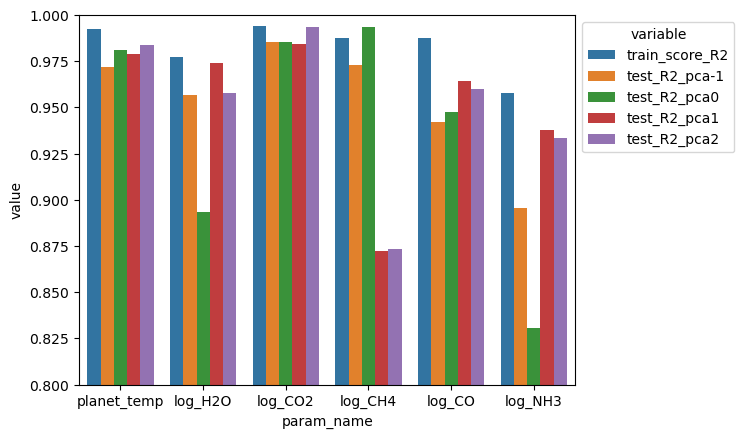

In [12]:
df_bar = pd.melt(
    totes_metriques[['param_name', 'train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2' ]], 
    id_vars=['param_name'], 
    value_vars=['train_score_R2', 'test_R2_pca-1', 'test_R2_pca0', 'test_R2_pca1','test_R2_pca2']
)

ax = sns.barplot(data=df_bar, x="param_name", y="value", hue="variable")
plt.ylim(0.8, 1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Comparacó entre els valors predits i els esperats

### Per totes les mostres del conjunt test 

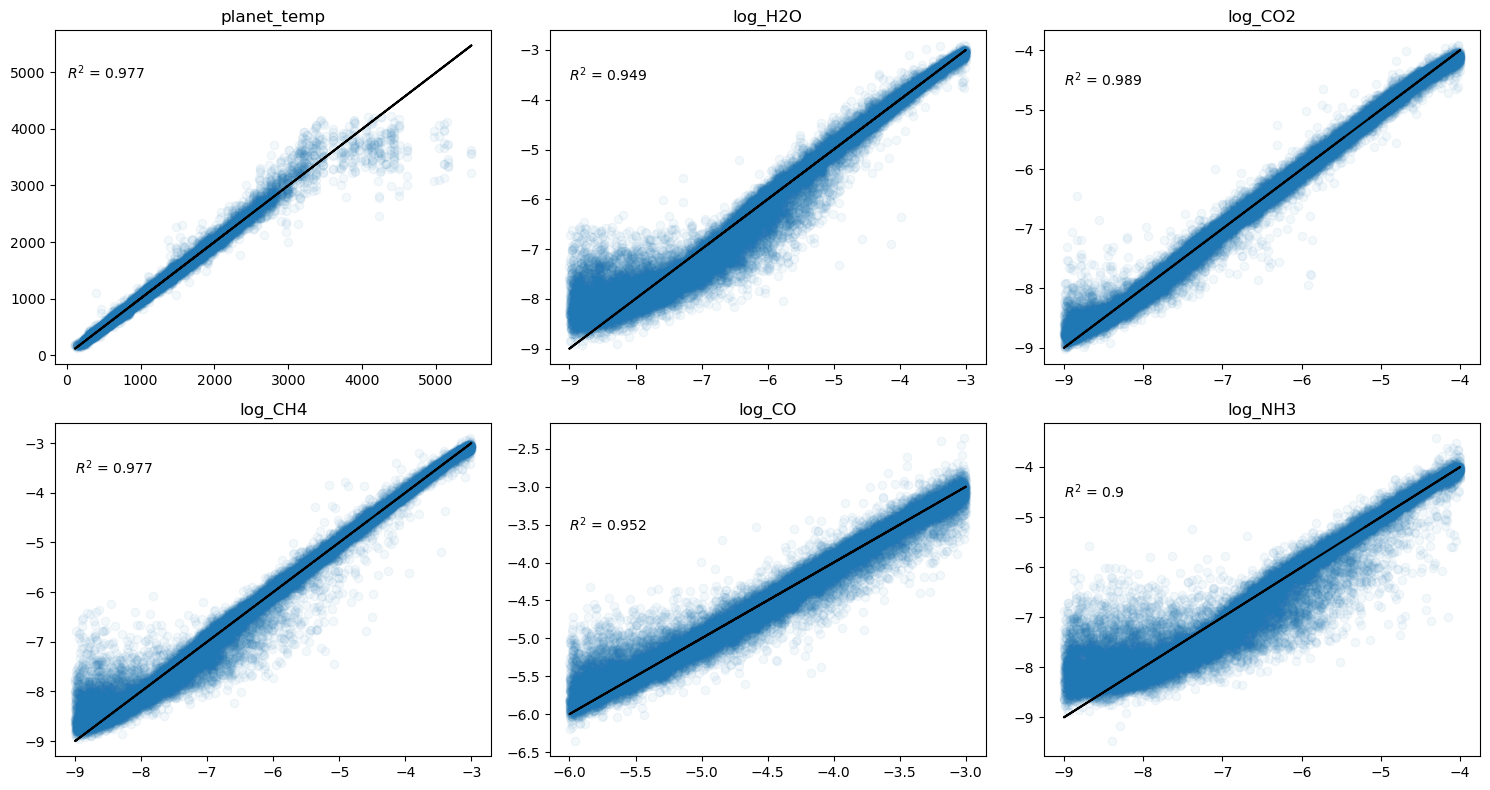

In [13]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level) #, c=pca_labels_test
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

### Per cada grup espectral per separat

Els grups espectrals són grups d'espectres amb característiques més homoegènies, determinats amb PCA + DBSCAN.

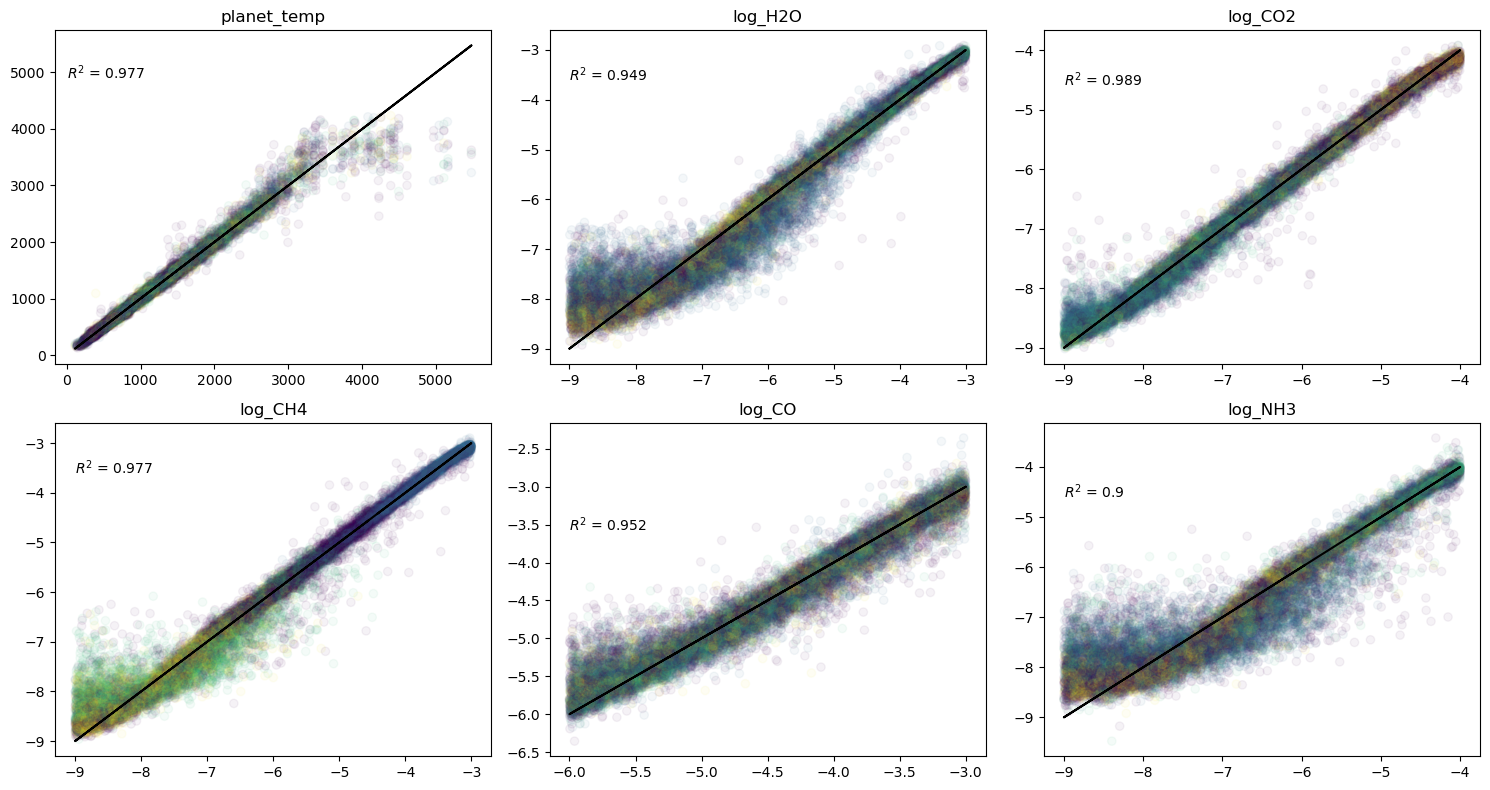

In [14]:
alpha_level = 0.05

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

x = y_test_all[:,0]; y = y_pred_df[param_names[0]]
axes[0,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test) 
axes[0,0].plot(x, x,'k-')
axes[0,0].set(title = param_names[0])
R2 = r2_score(x, y)
axes[0,0].text(0, 5000, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,1]; y = y_pred_df[param_names[1]]
axes[0,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,1].plot(x, x, 'k-')
axes[0,1].set(title = param_names[1])
R2 = r2_score(x, y)
axes[0,1].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,2]; y = y_pred_df[param_names[2]]
axes[0,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[0,2].plot(x, x,'k-')
axes[0,2].set(title = param_names[2])
R2 = r2_score(x, y)
axes[0,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,3]; y = y_pred_df[param_names[3]]
axes[1,0].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,0].plot(x, x,'k-')
axes[1,0].set(title = param_names[3])
R2 = r2_score(x, y)
axes[1,0].text(-9, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,4]; y = y_pred_df[param_names[4]]
axes[1,1].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,1].plot(x, x,'k-')
axes[1,1].set(title = param_names[4])
R2 = r2_score(x, y)
axes[1,1].text(-6, -3.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

x = y_test_all[:,5]; y = y_pred_df[param_names[5]]
axes[1,2].scatter(x, y, alpha = alpha_level, c=pca_labels_test)
axes[1,2].plot(x, x,'k-')
axes[1,2].set(title = param_names[5])
R2 = r2_score(x, y)
axes[1,2].text(-9, -4.5, '$R^2$ = ' + str(round(R2,3)), horizontalalignment='left', verticalalignment='center')

plt.tight_layout()
plt.show()

In [15]:
def get_y_pred(nParam):
    # Dades y_test per aquest parametre
    y_test = y_test_all[:, nParam]
    y_train = y_train_all[:, nParam]
    
    # Model d'aquest paràmetre
    model = pickle.load(open("/kaggle/working/GBmodel_param"+str(nParam), "rb"))
    
    # Calculem les prediccions del conjunt test
    y_pred = model.predict(X_test)
    
    return(y_pred)

In [16]:
def scatterplot_by_group(nParam):

    df = pd.DataFrame()
    df['y_pred'] = get_y_pred(nParam)
    df['y_true'] = y_test_all[:,nParam]
    df['pca_label'] = pca_labels_test

    sns.relplot(data=df, x="y_true", y="y_pred", hue="pca_label", col="pca_label", alpha=0.1)

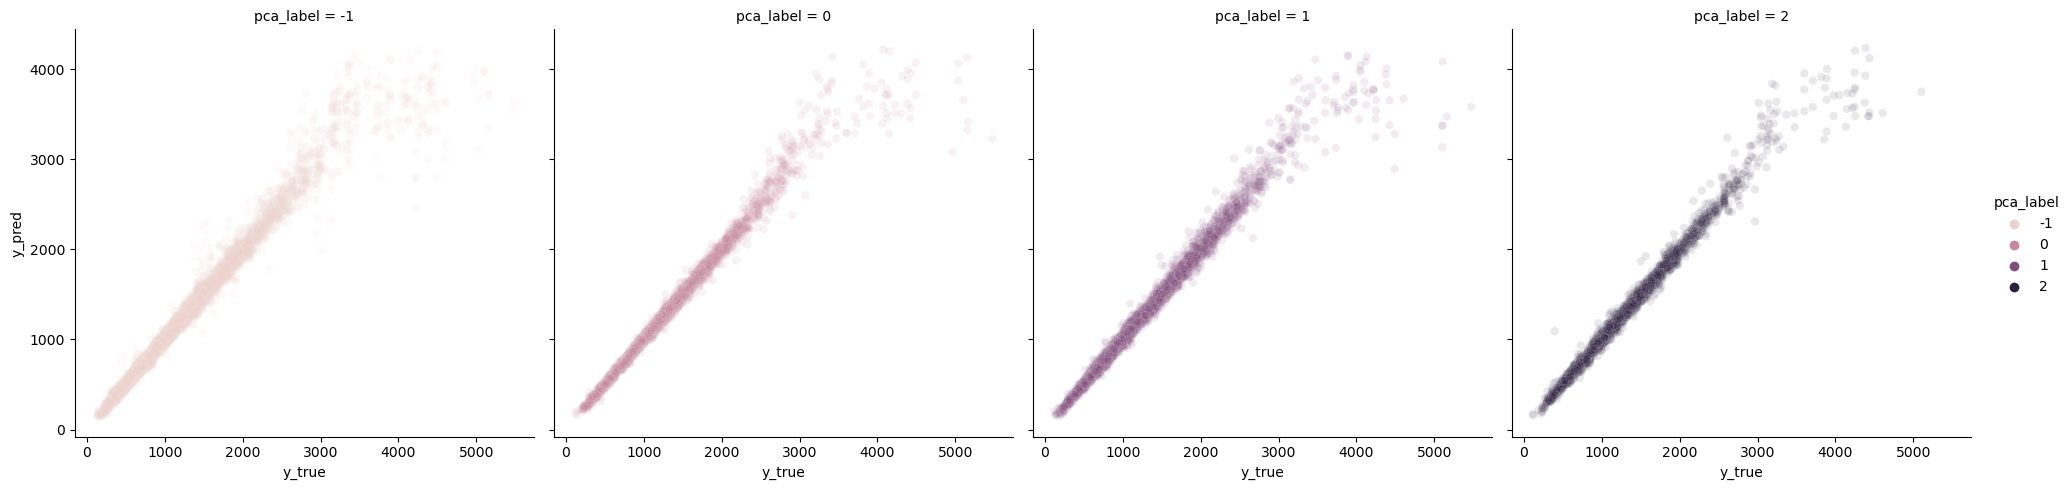

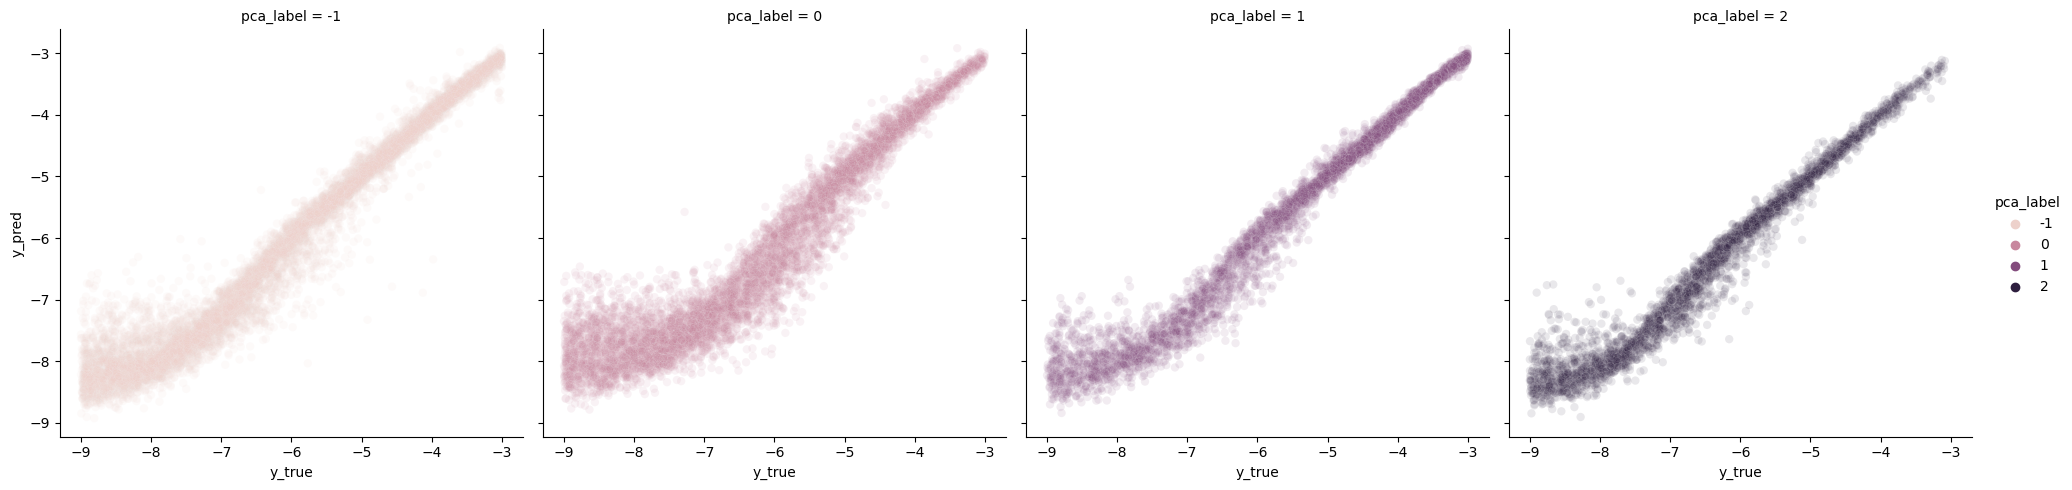

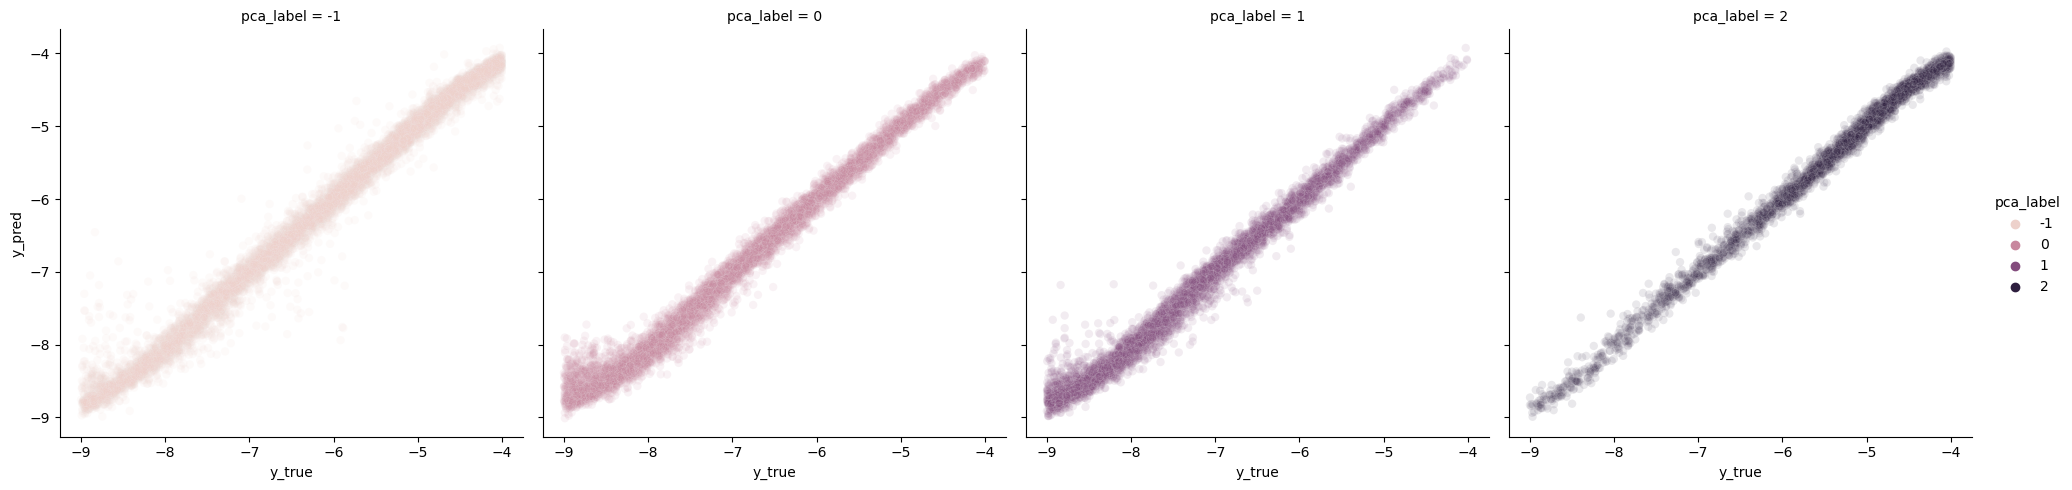

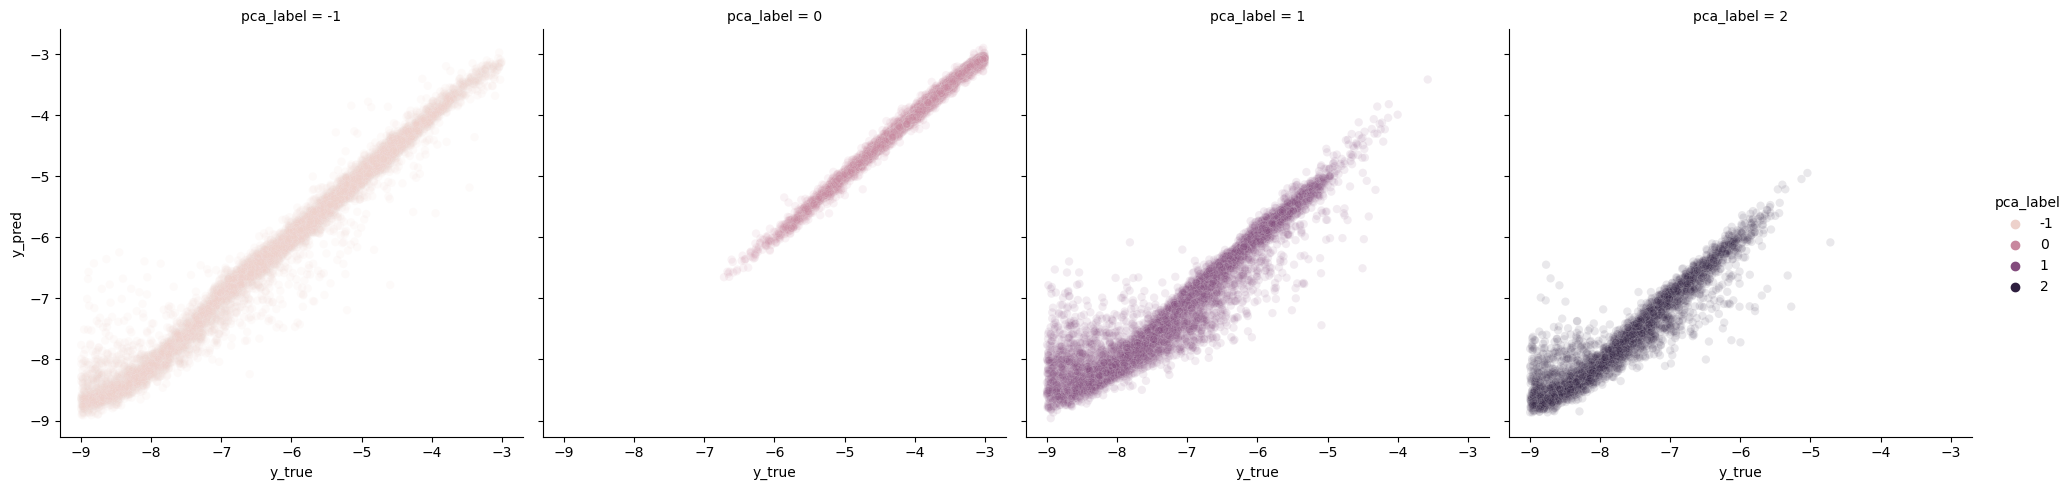

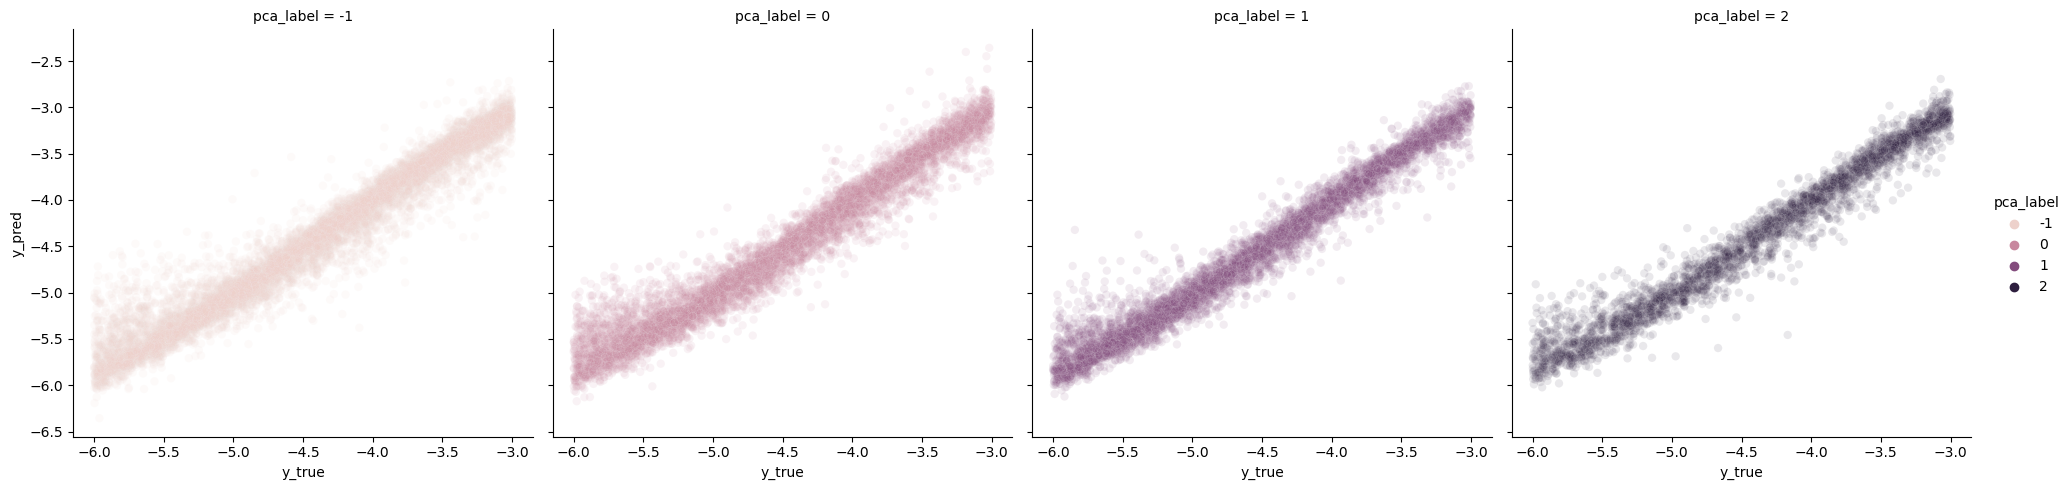

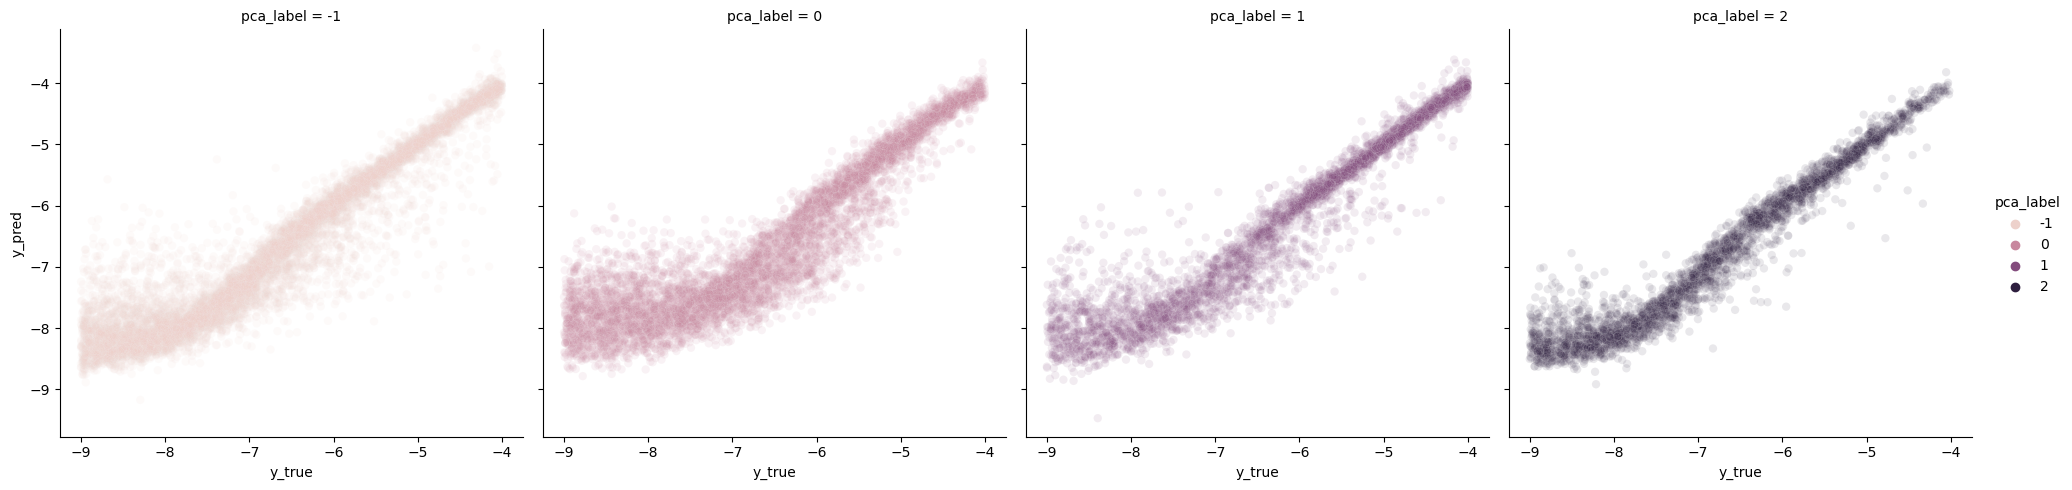

In [17]:
for i in range(0,6):
    scatterplot_by_group(i)